In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import numpy as np
import scipy as sp
import math
import torch
import optuna
import torch.autograd as autograd
import matplotlib.pyplot as plt
import inspect
import textwrap
import time

from typing import Callable
from torch import nn, optim
from sklearn.model_selection import KFold
from data_PINN import diffeq, create_trainig_test_set, create_trainig_validation_test_set
from tqdm import tqdm

import torch.nn.functional as F

torch.use_deterministic_algorithms(True)

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"

print(device)

cuda


## Defining the differential equation

We are using the differential equation of a harmonic oscillator:

$m \frac{d^2 x}{dt^2} +kx = 0 \Rightarrow \frac{d^2 x}{dt^2} +kx = 0 ~(m=1)$

In [4]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [5]:
#define the harmonic oscillator class (which ode's, number of variables: x,y, number of arguments: k)
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

# 1. Generating datasets

In [6]:
train, _, test = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.699, 0.001, 0.3], "analytic_harmonic", device=device, seed=0)

# 2. Defining the model

In [7]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in: int, n_hidden_layers: int, hidden_neurons: list, activation: str):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, hidden_neurons[0]))
        for i in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_neurons[i], hidden_neurons[i+1]))
        layers.append(nn.Linear(hidden_neurons[-1], 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

In [8]:
def calculate_validation_l2(model, val_data):
    """
    Calculates the Relative L2 Error on the validation set.
    Formula: (y_pred - y_true)^2 / (y_true)^2
    """
    model.eval()
    with torch.no_grad():
        X_val = val_data["X"].to(device)
        
        y_true = val_data["y_tensor"].to(device)
        y_pred = model(X_val).squeeze(-1)
        
        # Calculate L2 Relative Error
        error_norm = torch.norm(y_pred - y_true, p=2)
        true_norm = torch.norm(y_true, p=2)
        l2_error = error_norm / true_norm

        mse = torch.mean((y_pred - y_true)**2)
        
    return mse.item()

In [9]:
def loss_PINN(model, y_pred, y_exp, x_00, x_01, t, k, N_f, l_y, l_f, seed=0):    
    # 1. Calculate Data Loss (Standard)
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    # 2. Physics Loss Setup
    torch.manual_seed(seed)
    
    # We accumulate the VALUE of the loss for reporting, 
    # but we will rely on the return statement to keep the graph alive.
    mse_f_total = 0.0
    
    batch_size_f = 256
    num_batches = (N_f + batch_size_f - 1) // batch_size_f

    # Create the lists to hold the partial losses
    # We cannot sum them immediately into a single variable in a loop efficiently 
    # without risking the graph getting too deep or VRAM issues if not careful.
    # However, for this specific structure, summing them is fine IF we process small batches.
    
    loss_f_components = []

    for i in range(num_batches):
        N_f_c = min(batch_size_f, N_f)
        N_f -= N_f_c

        # Generate data on the fly (Low VRAM)
        t_f = (torch.max(t) * torch.rand(N_f_c).to(device)).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True)
        k_f = k.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f_c, 1)
        x_00_f = x_00.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f_c, 1)
        x_01_f = x_01.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f_c, 1)

        X_batch = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)

        y_b = model(X_batch)
        
        # Calculate Derivatives
        x_t = autograd.grad(y_b, t_f, grad_outputs=torch.ones_like(y_b), create_graph=True, allow_unused=True)[0]
        x_tt = autograd.grad(x_t, t_f, grad_outputs=torch.ones_like(x_t), create_graph=True, allow_unused=True)[0]

        f_res = x_tt + k_f * y_b
        
        # Calculate batch mean
        batch_mse = torch.mean(f_res**2)
        
        # Store the component connected to the graph
        # We divide by num_batches here to correctly average later
        loss_f_components.append(batch_mse / num_batches)
        
        # Clean up intermediate tensors to help VRAM
        del X_batch, t_f, k_f, y_b, x_t, x_tt, f_res

    # Sum the components (This keeps the Gradient Graph intact!)
    mse_f = torch.stack(loss_f_components).sum()

    return l_y*mse_y + l_f*mse_f

In [10]:
def train_PINN(
    model_class,
    model_args,
    n_splits,
    l_y,
    l_f,
    optimizer_class,
    lr,
    epochs,
    N_f,
    data,
    random_state=0,
    show_progress=False,
):
    X_full = data["X"]                  # shape: [N_samples, T, 4]
    y_exp_full = data["y_tensor"][:, :, 0].to(device)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_model = None
    best_loss = float("inf")

    for fold_id, (train_idx, val_idx) in enumerate(kf.split(X_full)):
        if show_progress:
            print(f"-----Fold: {fold_id + 1}-----")

        X_train = X_full[train_idx].to(device)
        y_train = y_exp_full[train_idx]

        X_val = X_full[val_idx].to(device)
        y_val = y_exp_full[val_idx]

        model = model_class(*model_args).to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr)

        t_train = X_train[:, :, 3]        # [N_train, T]
        t_min = t_train.min()
        t_max = t_train.max()
        
        k_train   = X_train[:, 0, 0:1].detach()  # [N_train, 1]
        x00_train = X_train[:, 0, 1:2].detach()
        x01_train = X_train[:, 0, 2:3].detach()
        
        n_train = X_train.shape[0]
        batch_size_f = 400
        num_batches = max(1, (N_f + batch_size_f - 1) // batch_size_f)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
        
            # ---------- DATA LOSS ----------
            y_pred = model(X_train).squeeze(-1)    # [N_train, T]
            mse_y = torch.mean((y_pred - y_train)**2)
            loss_data = l_y * mse_y
            loss_data.backward(retain_graph=False)
        
            # ---------- PHYSICS LOSS ----------
            total_mse_f = 0.0
        
            for b in range(num_batches):
                if b < num_batches - 1:
                    N_batch = batch_size_f
                else:
                    N_batch = N_f - batch_size_f * (num_batches - 1)
                    if N_batch <= 0:
                        N_batch = batch_size_f
        
                # 1) Randomly sample parameter indices
                idx_param = torch.randint(0, n_train, (N_batch,), device=device)
        
                k_f   = k_train[idx_param]      # [N_batch, 1]
                x00_f = x00_train[idx_param]    # [N_batch, 1]
                x01_f = x01_train[idx_param]    # [N_batch, 1]
        
                # 2) Sample times in [t_min, t_max]
                t_f = t_min + (t_max - t_min) * torch.rand(N_batch, 1, device=device)
                t_f.requires_grad_(True)
        
                # 3) Build collocation input and forward
                X_f_batch = torch.cat([k_f, x00_f, x01_f, t_f], dim=1)  # [N_batch, 4]
                y_f = model(X_f_batch)                                  # [N_batch, 1]
        
                # 4) First and second derivatives wrt t
                x_t = autograd.grad(
                    outputs=y_f,
                    inputs=t_f,
                    grad_outputs=torch.ones_like(y_f),
                    create_graph=True,
                )[0]
        
                x_tt = autograd.grad(
                    outputs=x_t,
                    inputs=t_f,
                    grad_outputs=torch.ones_like(x_t),
                    create_graph=True,
                )[0]
        
                # 5) Residual and batch loss
                f_res = x_tt + k_f * y_f
                mse_f_batch = torch.mean(f_res**2)
        
                loss_phys_batch = (l_f * mse_f_batch) / num_batches
                loss_phys_batch.backward()
        
                total_mse_f += mse_f_batch.item()
        
                del X_f_batch, t_f, y_f, x_t, x_tt, f_res, loss_phys_batch
        
            avg_mse_f = total_mse_f / num_batches
            total_loss_val = l_y * mse_y.item() + l_f * avg_mse_f
        
            optimizer.step()
        
            if (epoch + 1) % max(1, int(epochs / 10)) == 0 and show_progress:
                print(
                    f"Epoch {epoch+1}/{epochs}, "
                    f"Loss: {total_loss_val:.4f}, "
                    f"Data MSE: {mse_y.item():.4e}, "
                    f"Phys MSE: {avg_mse_f:.4e}"
                )

            # ---------- VALIDATION ----------
            if (epoch + 1) == epochs:
                val_err = calculate_validation_l2(
                    model, {"X": X_val, "y_tensor": y_val}
                )
                if (epoch + 1) % max(1, int(epochs / 10)) == 0 and show_progress:
                    print(f'MSE = {val_err}')
                if val_err < best_loss:
                    best_loss = val_err
                    best_model = model

    return best_model, best_loss


# 3. Optimizing hyperparameters

We use the structure of the optimized NN model to keep NN and PINN comparable in "complexity".

In [11]:
model_init = HarmonicModel(4, 4, [82, 119, 46, 124], 'sine').to(device)
model_init

HarmonicModel(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=82, bias=True)
    (1): Linear(in_features=82, out_features=119, bias=True)
    (2): Linear(in_features=119, out_features=46, bias=True)
    (3): Linear(in_features=46, out_features=124, bias=True)
    (4): Linear(in_features=124, out_features=1, bias=True)
  )
)

Before doing the hyperparameter optimization we want to define $l_f$ and $N_f$ such that they have a meaningful impact on the model.

In [13]:
l_f_candidates = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
l_y_fixed = 1.0  # Keep data loss weight fixed
l2_errors = []

print(f"Starting for l_f values: {l_f_candidates}\n")

for l_f_val in l_f_candidates:
    print(f"Testing l_f = {l_f_val} ...")
    
    model_args = (4, 4, [82, 119, 46, 124], 'sine')
    
    best_model, _ = train_PINN(
        model_class=HarmonicModel,
        model_args=model_args,
        n_splits=5,             
        l_y=l_y_fixed,
        l_f=l_f_val,
        optimizer_class=optim.Adam,
        lr=1e-3,
        epochs=100,     
        N_f=10000,
        data=train,            
        show_progress=False
    )
    
    val_error = calculate_validation_l2(best_model, {'X': test["X"].to(device), 'y_tensor': test["y_tensor"][:, :, 0].to(device)})
    l2_errors.append(val_error)
    
    print(f"-> l_f: {l_f_val} | Validation L2 Error: {val_error:.4e}")

# 3. Visualize Results
best_idx = np.argmin(l2_errors)
best_l_f = l_f_candidates[best_idx]

print(f"\nRecommended l_f: {best_l_f} (Lowest Relative MSE: {l2_errors[best_idx]:.4e})")

Starting for l_f values: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

Testing l_f = 0.001 ...
-> l_f: 0.001 | Validation L2 Error: 4.3201e-01
Testing l_f = 0.01 ...
-> l_f: 0.01 | Validation L2 Error: 3.5873e-01
Testing l_f = 0.1 ...
-> l_f: 0.1 | Validation L2 Error: 5.0811e-01
Testing l_f = 1.0 ...
-> l_f: 1.0 | Validation L2 Error: 4.3650e-01
Testing l_f = 10.0 ...
-> l_f: 10.0 | Validation L2 Error: 7.0194e-01
Testing l_f = 100.0 ...
-> l_f: 100.0 | Validation L2 Error: 9.5081e-01
Testing l_f = 1000.0 ...
-> l_f: 1000.0 | Validation L2 Error: 1.0456e+00
Testing l_f = 10000.0 ...
-> l_f: 10000.0 | Validation L2 Error: 1.0506e+00

Recommended l_f: 0.01 (Lowest Relative MSE: 3.5873e-01)


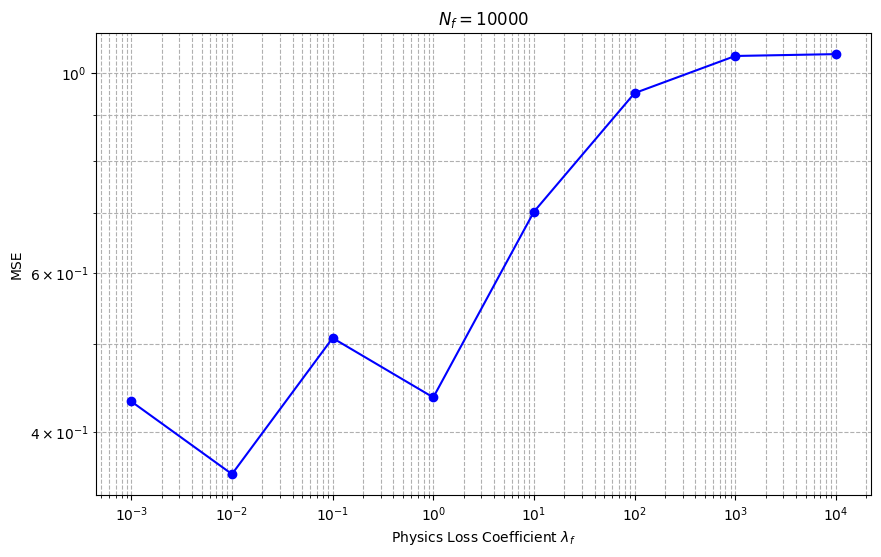

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(l_f_candidates, l2_errors, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Physics Loss Coefficient $\lambda_f$')
plt.ylabel('MSE')
plt.title(r'$N_f = 10000$')
plt.grid(True, which="both", ls="--")
plt.savefig("Figures/lf_curve")
plt.show()

In [15]:
N_f_candidates = [100, 500, 1000, 2500, 5000, 10000, 20000, 40000, 80000, 160000]

l_f_fixed = 10
l_y_fixed = 1.0

nf_errors = []
nf_times = []

print(f"Starting sweep for N_f values: {N_f_candidates}")
print(f"Fixed l_f: {l_f_fixed}\n")

for N_f_val in N_f_candidates:
    print(f"Testing N_f = {N_f_val} ...")
    
    start_time = time.time()

    model_args = (4, 4, [82, 119, 46, 124], 'sine')
    
    best_model, _ = train_PINN(
        model_class=HarmonicModel,
        model_args=model_args,
        n_splits=3,
        l_y=l_y_fixed,
        l_f=l_f_fixed,
        optimizer_class=optim.Adam,
        lr=1e-3,
        epochs=100,          
        N_f=N_f_val,  
        data=train,
        show_progress=False
    )
    
    # Stop Timer
    elapsed = time.time() - start_time
    
    # Evaluate
    val_error = calculate_validation_l2(best_model, {'X': test["X"].to(device), 'y_tensor': test["y_tensor"][:, :, 0].to(device)})
    
    nf_errors.append(val_error)
    nf_times.append(elapsed)
    
    print(f"-> N_f: {N_f_val} | Val Error: {val_error:.4e} | Time: {elapsed:.2f}s")


Starting sweep for N_f values: [100, 500, 1000, 2500, 5000, 10000, 20000, 40000, 80000, 160000]
Fixed l_f: 10

Testing N_f = 100 ...
-> N_f: 100 | Val Error: 7.4735e-01 | Time: 2.13s
Testing N_f = 500 ...
-> N_f: 500 | Val Error: 7.3401e-01 | Time: 3.88s
Testing N_f = 1000 ...
-> N_f: 1000 | Val Error: 7.2641e-01 | Time: 5.58s
Testing N_f = 2500 ...
-> N_f: 2500 | Val Error: 7.4076e-01 | Time: 11.98s
Testing N_f = 5000 ...
-> N_f: 5000 | Val Error: 7.0159e-01 | Time: 21.17s
Testing N_f = 10000 ...
-> N_f: 10000 | Val Error: 5.9147e-01 | Time: 40.62s
Testing N_f = 20000 ...
-> N_f: 20000 | Val Error: 7.1885e-01 | Time: 78.99s
Testing N_f = 40000 ...
-> N_f: 40000 | Val Error: 7.0638e-01 | Time: 155.19s
Testing N_f = 80000 ...
-> N_f: 80000 | Val Error: 7.1435e-01 | Time: 307.66s
Testing N_f = 160000 ...
-> N_f: 160000 | Val Error: 7.1707e-01 | Time: 613.36s


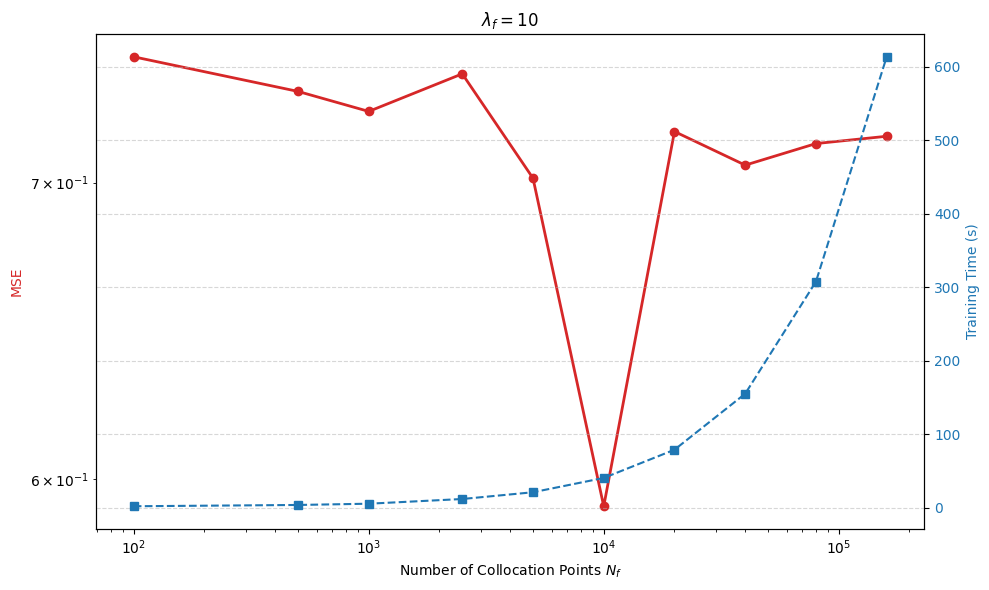

In [73]:
#Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Collocation Points $N_f$')
ax1.set_ylabel('MSE', color=color)
ax1.plot(N_f_candidates, nf_errors, marker='o', color=color, linewidth=2, label='Error')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log') # Log scale helps visualize the orders of magnitude
ax1.set_yscale('log')

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Training Time (s)', color=color)  
ax2.plot(N_f_candidates, nf_times, marker='s', linestyle='--', color=color, label='Time')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(r'$\lambda _f=10$')
fig.tight_layout()  
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.savefig("Figures/Nf_curve")
plt.show()

In [32]:
def objective(trial):

    #Model hyperparemeters
    #n_hidden_layers = trial.suggest_int("n_hidden_layers", 2, 5)
    #hidden_neurons = [trial.suggest_int(f"n_neurons{i}", 4, 128, log=True) for i in range(n_hidden_layers)]
    #activation = trial.suggest_categorical("activation", ["tanh", "sine", "relu", "gelu"])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    #Loss function hyperparameters
    #l_y = trial.suggest_float("l_y", 0.1, 10.0, log=True)
    l_f = trial.suggest_float("l_f", 0.001, 1000.0, log=True)
    N_f = trial.suggest_int("N_f", 1000, 50000) #to change

    #Training hyperparameters
    #epochs = trial.suggest_int("epochs", 10, 200) #to change
    #n_splits = trial.suggest_int("n_splits", 2, 10)
    #optimizers = [torch.optim.Adam, torch.optim.SGD, 
    #              torch.optim.RMSprop, torch.optim.Adagrad,
    #              torch.optim.ASGD, torch.optim.Rprop]
    #optimizer_idx = trial.suggest_int("optimizer_idx", 0, len(optimizers) - 1)
    #optimizer_class = optimizers[optimizer_idx]

    #model_args = (4, n_hidden_layers, hidden_neurons, activation)

    #Training using K-fold
    best_model, best_loss = train_PINN(
        model_class=HarmonicModel,
        model_args=(4, 5, [111, 87, 25, 63, 41], 'sine'),
        n_splits=5,
        l_y=1,
        l_f=l_f,
        optimizer_class=torch.optim.Adam,
        lr=lr,
        epochs=100,
        N_f=N_f,
        data=train,
        random_state=trial.number,
        show_progress=False
    )

    return best_loss

In [33]:
study = optuna.create_study(
    #sampler=optuna.samplers.TPESampler(seed=0),
    study_name="PINN_harmonic_oscillator",
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=10)
)

study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

[I 2025-12-11 23:13:20,805] A new study created in memory with name: PINN_harmonic_oscillator


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-11 23:18:25,368] Trial 0 finished with value: 0.5018934607505798 and parameters: {'lr': 0.0003885096973783046, 'l_f': 0.7319192422347996, 'N_f': 15503}. Best is trial 0 with value: 0.5018934607505798.
[I 2025-12-11 23:29:08,802] Trial 1 finished with value: 0.01844373345375061 and parameters: {'lr': 0.004995089012380298, 'l_f': 0.0014581229273599554, 'N_f': 32344}. Best is trial 1 with value: 0.01844373345375061.
[I 2025-12-11 23:35:02,362] Trial 2 finished with value: 0.5168774127960205 and parameters: {'lr': 0.00012586541906193298, 'l_f': 11.454218146876002, 'N_f': 19973}. Best is trial 1 with value: 0.01844373345375061.
[I 2025-12-11 23:42:12,234] Trial 3 finished with value: 0.6628918647766113 and parameters: {'lr': 0.001860733553297746, 'l_f': 141.52600706584218, 'N_f': 40245}. Best is trial 1 with value: 0.01844373345375061.
[I 2025-12-11 23:45:01,177] Trial 4 finished with value: 0.4145340919494629 and parameters: {'lr': 0.0004991270182182746, 'l_f': 0.008753331665264

In [34]:
print("Best hyperparameters:", study.best_trial.params)
print("Best value:", study.best_value)

Best hyperparameters: {'lr': 0.009816271309921182, 'l_f': 0.08841041746970582, 'N_f': 2178}
Best value: 0.010227425955235958


In [36]:
torch.cuda.empty_cache()

best_model_new, best_loss_new = train_PINN(HarmonicModel, 
                                    (4, 5, [111, 87, 25, 63, 41], 'sine'), 
                                    n_splits=5,
                                    l_y=1,
                                    l_f=0.08841041746970582,
                                    optimizer_class=torch.optim.Adam, 
                                    lr= 0.009816271309921182,
                                    epochs=1000, 
                                    N_f=2178, 
                                    data=train, 
                                    random_state=0,
                                    show_progress=True
                                   )

-----Fold: 1-----
Epoch 100/1000, Loss: 0.0212, Data MSE: 1.9617e-02, Phys MSE: 1.7354e-02
Epoch 200/1000, Loss: 0.0033, Data MSE: 2.8721e-03, Phys MSE: 4.6494e-03
Epoch 300/1000, Loss: 0.0027, Data MSE: 2.3993e-03, Phys MSE: 3.0385e-03
Epoch 400/1000, Loss: 0.0126, Data MSE: 1.2345e-02, Phys MSE: 2.8923e-03
Epoch 500/1000, Loss: 0.0025, Data MSE: 2.3728e-03, Phys MSE: 1.4619e-03
Epoch 600/1000, Loss: 0.0043, Data MSE: 4.1391e-03, Phys MSE: 1.3532e-03
Epoch 700/1000, Loss: 0.0016, Data MSE: 1.4672e-03, Phys MSE: 1.3793e-03
Epoch 800/1000, Loss: 0.0004, Data MSE: 3.5288e-04, Phys MSE: 8.3328e-04
Epoch 900/1000, Loss: 0.0009, Data MSE: 7.9501e-04, Phys MSE: 1.1094e-03
Epoch 1000/1000, Loss: 0.0013, Data MSE: 1.2257e-03, Phys MSE: 9.0189e-04
MSE = 0.0037006011698395014
-----Fold: 2-----
Epoch 100/1000, Loss: 0.0453, Data MSE: 4.3384e-02, Phys MSE: 2.1183e-02
Epoch 200/1000, Loss: 0.0048, Data MSE: 4.3414e-03, Phys MSE: 4.9427e-03
Epoch 300/1000, Loss: 0.0017, Data MSE: 1.4665e-03, Phys MS

In [38]:
best_model_new, best_loss_new

(HarmonicModel(
   (layers): ModuleList(
     (0): Linear(in_features=4, out_features=111, bias=True)
     (1): Linear(in_features=111, out_features=87, bias=True)
     (2): Linear(in_features=87, out_features=25, bias=True)
     (3): Linear(in_features=25, out_features=63, bias=True)
     (4): Linear(in_features=63, out_features=41, bias=True)
     (5): Linear(in_features=41, out_features=1, bias=True)
   )
 ),
 0.0007452596328221262)

In [58]:
#Save the model
torch.save(best_model_new, "optimized_model_PINN_final2.pt")

In [32]:
#Load a model
best_model_new = HarmonicModel(4, 4, [82, 119, 46, 124], 'sine').to(device)
best_model_new.load_state_dict(torch.load("optimized_model_PINN_final2.pt"))
best_model_new.eval()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.HarmonicModel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.HarmonicModel])` or the `torch.serialization.safe_globals([__main__.HarmonicModel])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [46]:
# test dataset
X = test["X"]
y_exp = test["y_tensor"][0:, 0:, 0].to(device)
y_pred = best_model_new(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
#test_loss = loss_PINN(best_model_new, y_pred, y_exp, x_00, x_01, t, k, N_f=174, l_y=1, l_f=1)
test_loss = calculate_validation_l2(best_model_new, {'X': test["X"].to(device), 'y_tensor': test["y_tensor"][:, :, 0].to(device)})
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0070


torch.Size([300, 100])


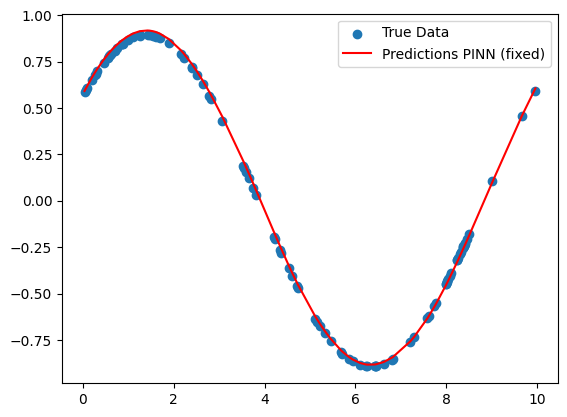

In [60]:
print(y_pred.shape)
y_pred.to("cpu")
test["t_tensor"].to("cpu")

n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions PINN (fixed)")
plt.legend()
plt.show()

In [48]:
def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset

In [49]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, validation_no_noise, test_no_noise = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1, [0.699, 0.001, 0.3], "analytic_harmonic", device=device, seed=0)

# Example: add noise with std=0.1 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
validation_noise = add_noise_to_dataset(validation_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]
y_pred_noise = best_model_new(X).squeeze(-1)
y_exp = test_noise["y_tensor"][0:, 0:, 0].to(device)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]

test_loss = calculate_validation_l2(best_model_new, {"X": X, "y_tensor": y_exp.unsqueeze(1)})
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.1980


/tmp/ipykernel_529628/3587481043.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


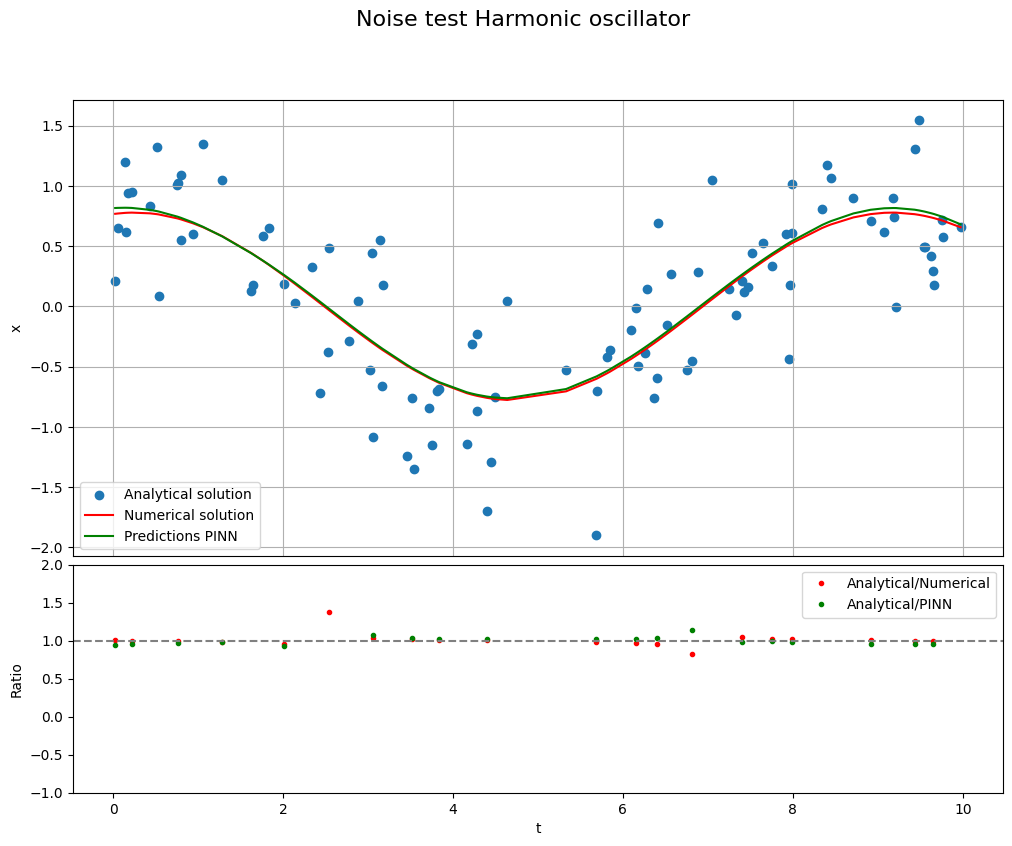

In [50]:
n = 0

y_pred_noise.to(device)
test_noise["t_tensor"].to(device)

#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]
w = test_noise["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_no_noise["y_tensor"][n][0:, 0]/y_pred_noise.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise.cpu().detach()[n], color="green", label="Predictions PINN") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/PINN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Noise test Harmonic oscillator", fontsize=16)
plt.show()

In [53]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 200, 1, [0.699, 0.001, 0.3], "analytic_harmonic", device=device, seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_generalization = best_model_new(X).squeeze(-1)
y_exp_generalization = test_generalization["y_tensor"][0:, 0:, 0].to(device)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]

test_loss = loss_PINN(best_model_new, y_pred_generalization, y_exp_generalization, x_00, x_01, t, k, N_f=174, l_y=1, l_f=1)
print(f"Test Loss Random optimization: {test_loss:.4f}")

Test Loss Random optimization: 1.5605


/tmp/ipykernel_529628/598000354.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


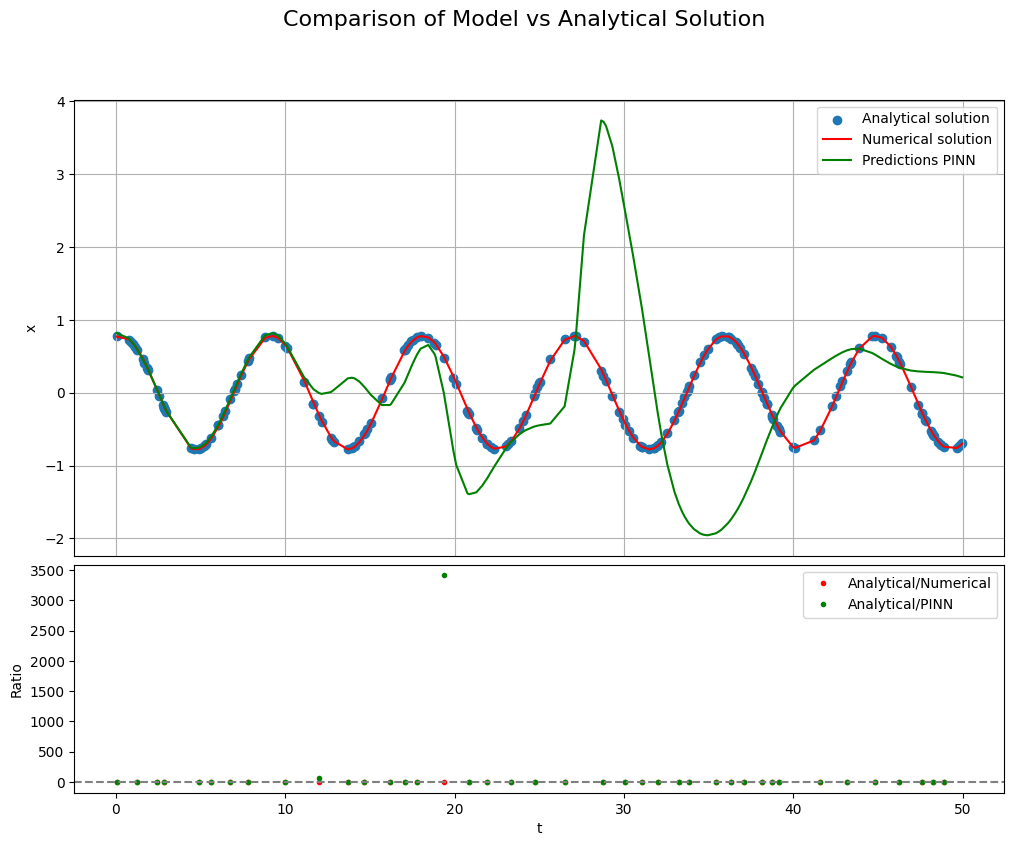

In [54]:
n = 0

y_pred_generalization.to(device)
test_generalization["t_tensor"].to(device)

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
w = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_generalization["y_tensor"][n][0:, 0]/y_pred_generalization.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization.cpu().detach()[n], color="green", label="Predictions PINN") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/PINN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
#ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Comparison of Model vs Analytical Solution", fontsize=16)
plt.show()

Initial energy E0 = 1.709419e-01
Max absolute deviation = 3.982335e+00
Max relative deviation = 2.329642e+01


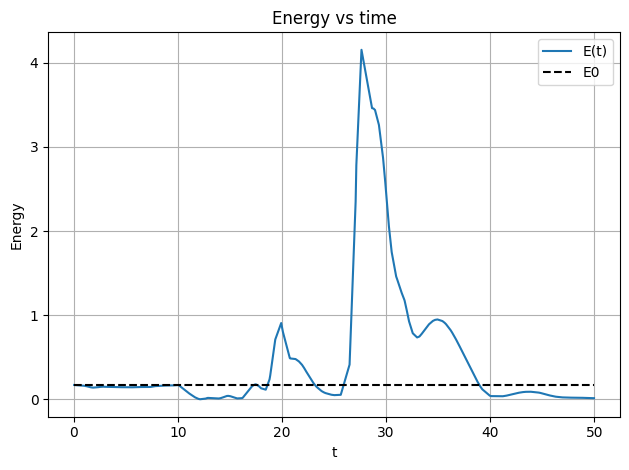

In [55]:
n = 0  # choose trajectory index

# Position
x = y_pred_generalization[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v = np.gradient(x, t)

#Energy conservation (check on generalized data)
E_t = 0.5 * v**2 + 0.5 * float(w) * x**2
E0 = E_t[0]

# diagnostics
abs_dev = np.max(np.abs(E_t - E0))
rel_dev = np.max(np.abs((E_t - E0) / E0))

print(f"Initial energy E0 = {E0:.6e}")
print(f"Max absolute deviation = {abs_dev:.6e}")
print(f"Max relative deviation = {rel_dev:.6e}")

plt.plot(test_generalization["t_tensor"][n], E_t, label='E(t)')
plt.hlines(E0, sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
#plt.ylim(0,2)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('Energy vs time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [51]:
n=0

#Computation time
N = 200
timesteps_NN = np.zeros(N)
timesteps_Num = np.zeros(N)
N_list = np.arange(0,N)

X = test["X"][n]
y0 = [test["x0_tensor"][n][0], test["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test["t_tensor"][n][0], test["t_tensor"][n][-1]
w = test["args_tensor"][n]

#NN
for i, el in tqdm(enumerate(N_list), desc="Computation time NN: "):
    begin = time.perf_counter()
    for _ in range(el):
        best_model_new(X)
    end = time.perf_counter()
    timesteps_NN[i] = end-begin

#Numerical
for i, el in tqdm(enumerate(N_list), desc="Computation time Numerical: "):
    begin = time.perf_counter()
    for _ in range(el):
        sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test["t_tensor"][n], method='RK45', args=(w))
    end = time.perf_counter()
    timesteps_Num[i] = end-begin

Computation time NN: : 200it [00:07, 25.08it/s]
Computation time Numerical: : 200it [00:42,  4.69it/s]


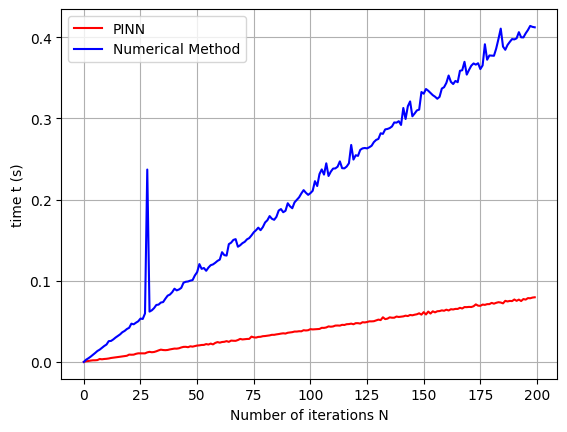

In [52]:
#Plot computational time
plt.plot(N_list, timesteps_NN, color='red', label="PINN")
plt.plot(N_list, timesteps_Num, color='blue', label="Numerical Method")
plt.xlabel("Number of iterations N")
plt.ylabel("time t (s)")
plt.grid(True)
plt.legend()
plt.show()

In [56]:
def plot_epochs_vs_accuracy(epoch_list, train_errors, test_errors, metric_name="L2 Relative Error"):
    """
    Plots the final Training and Test errors for different total epoch counts
    to determine the optimal stopping point and identify overfitting.
    
    Args:
        epoch_list (list): List of epoch counts tested (e.g., [100, 500, 1000]).
        train_errors (list): Final training error/loss corresponding to each epoch count.
        test_errors (list): Final test/validation error corresponding to each epoch count.
        metric_name (str): Label for the Y-axis.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot Training Error
    plt.plot(epoch_list, train_errors, marker='o', linestyle='-', color='blue', label='Training Error', linewidth=2)
    
    # Plot Test Error
    plt.plot(epoch_list, test_errors, marker='s', linestyle='--', color='red', label='Test Error', linewidth=2)

    plt.title("PINN (Fixed Architecture)")
    plt.xlabel('Number of Epochs')
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.4)
    
    # Use Log Scale if errors vary significantly (common in PINNs)
    if max(test_errors) / (min(test_errors) + 1e-9) > 50:
        plt.yscale('log')
        
    # Annotate the "Sweet Spot" (Minimum Test Error)
    min_test_err = min(test_errors)
    best_epoch_idx = test_errors.index(min_test_err)
    best_epoch = epoch_list[best_epoch_idx]

    plt.annotate(f'Optimal \n(Epochs: {best_epoch})', 
                 xy=(best_epoch, min_test_err*1.2), 
                 xytext=(best_epoch, min_test_err * 2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 horizontalalignment='center', fontweight='bold')
    
    plt.savefig("Figures/lc_PINN_fixed")
    plt.show()

In [40]:
def save_results_to_file(filename, epoch_list, train_errors, test_errors):
    """
    Saves the experiment results to a text file.
    Format: Epochs, Train_Error, Test_Error
    """
    with open(filename, "w") as f:
        f.write("Epochs,Train_Error,Test_Error\n")
        
        for e, tr, te in zip(epoch_list, train_errors, test_errors):
            f.write(f"{e},{tr:.8f},{te:.8f}\n")
            
    print(f"Results successfully saved to: {filename}")

In [41]:
# 1. Define the Epochs you want to test
epoch_candidates = [5, 10, 20, 40, 80, 100, 150, 200, 400, 600, 800, 1000, 2000, 5000, 10000]

final_train_errors = []
final_test_errors = []

# 2. Run the experiment
for n_epochs in epoch_candidates:
    print(f"Training for {n_epochs} epochs...")

    model, val_err = train_PINN(HarmonicModel, 
                                    (4, 5, [111, 87, 25, 63, 41], 'sine'), 
                                    n_splits=5,
                                    l_y=1,
                                    l_f=0.08841041746970582,
                                    optimizer_class=torch.optim.Adam, 
                                    lr= 0.009816271309921182, 
                                    epochs=n_epochs, 
                                    N_f=2178, 
                                    data=train, 
                                    random_state=0,
                                    show_progress=False
                                   )
    
    with torch.no_grad():
        test_err = calculate_validation_l2(model, {'X': test["X"].to(device), 'y_tensor': test["y_tensor"][:, :, 0].to(device)})
        
    final_train_errors.append(val_err)
    final_test_errors.append(test_err)

Training for 5 epochs...
Training for 10 epochs...
Training for 20 epochs...
Training for 40 epochs...
Training for 80 epochs...
Training for 100 epochs...
Training for 150 epochs...
Training for 200 epochs...
Training for 400 epochs...
Training for 600 epochs...
Training for 800 epochs...
Training for 1000 epochs...
Training for 2000 epochs...
Training for 5000 epochs...
Training for 10000 epochs...


In [43]:
#Save data
save_results_to_file("overfitting_experiment_PINN_final2.txt", epoch_candidates, final_train_errors, final_test_errors)

Results successfully saved to: overfitting_experiment_PINN_final2.txt


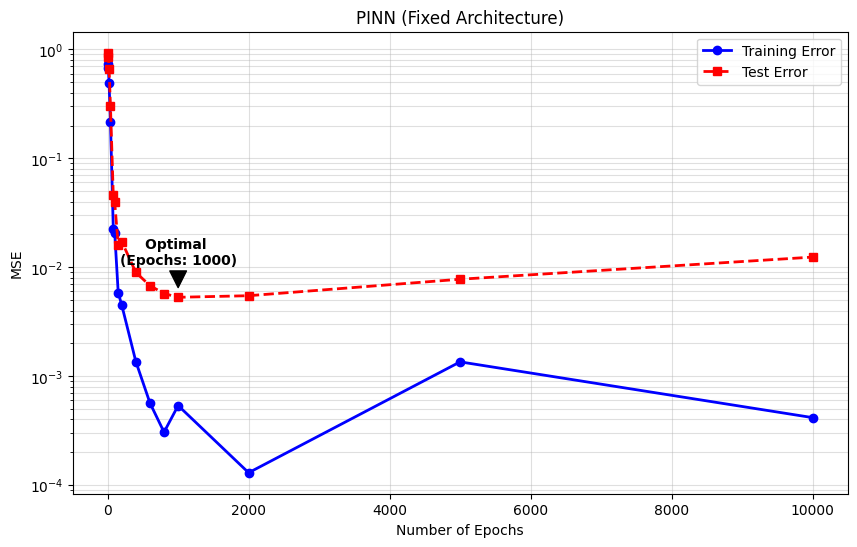

In [57]:
#Generate a plot
plot_epochs_vs_accuracy(epoch_candidates, final_train_errors, final_test_errors)